# INA Project

The data used was obtained from [here](https://zenodo.org/records/47317).
The files used contain network models of the European high-voltage power grid, extracted by [GridKit](https://github.com/bdw/GridKit). These extracts form a topological network with stations in one file (nodes.csv) and lines in another (edges.csv). OpenStreetMap is the primary data source.

Motivation (i think): On 28th April 2025, there was a major blackout of the Iberian Peninsula for a long period of time, this led us to think of how fragile can the European Electrical Grid be

Objectives? Guys at first i thought that we needed voltage to be able to do the second part of taking the type of the nodes into consideration but now I do not think so. The first part will be just treating the network as if all nodes are of the same type and perform attacks to check connectivity. Then the second part we will do almost the same think but after the attacks check the power of a node. It will have no power if there is not a path to a plant, du to this we will do specific attacks on plants and on substations (substations will disconnect paths to the plant), We can also do attacks on edges for all cases as they are cables and in real life we can obviously attack, we can even say that edges are easier to attack, but also easier to rebuild. 


When I ran the map with the types of nodes I see very little plants which might be concerning. We can first take all the nodes that do not have a path to a plant and only then we start the first part, doing this we are basically getting the LCC that has energy. But this is just an ideia maybe everything is connected. 

In [17]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
from operator import itemgetter
import random
#from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme()

## Creating the Graph from the data

In [18]:
node_csv = 'data/nodes.csv'
edge_csv = 'data/edges.csv'


# Read nodes with additional attributes
nodes = pd.read_csv(node_csv, usecols=[
    "v_id", "lon", "lat", "typ", "name", "operator", "voltage", "frequency"
])

# Read edges with additional attributes
edges = pd.read_csv(edge_csv, usecols=[
    "v_id_1", "v_id_2", "voltage", "cables", "wires", "frequency",
    "length_m", "r_ohmkm", "x_ohmkm", "c_nfkm", "i_th_max_a"
])
   
# 3) Build graph
G = nx.Graph()
    
# 3a) Add nodes with attributes
for _, row in nodes.iterrows():
    # parse voltage list and frequency
    '''voltage_str = str(row.voltage)
    if voltage_str and voltage_str != 'nan':
        voltages = [int(v) for v in voltage_str.split(";") if v]
    else:
        voltages = []  # will be inferred later
    #freq = float(row.frequency) if pd.notna(row.frequency) else None
    #   plant       → generation
    #   substation  → transmission
    #   transformer → distribution
    #   joint       → transmission'''
    typ_lower = row.typ.lower() if isinstance(row.typ, str) else ""
    if typ_lower == "plant":
        role = "generation"
    elif typ_lower in ("substation", "sub_station", "station"):
        role = "conversion"
    elif typ_lower in ("joint", "merge"):
            role = "transmission"
    else:
        role = "unknown"
        
    G.add_node(row.v_id, 
               pos=(row.lon, row.lat),
               typ=row.typ,
               role=role,
               name=row.name,
               operator=row.operator,
               voltage=row.voltage,
               frequency=row.frequency)

    
# 3b) Add edges
for _, row in edges.iterrows():
    G.add_edge(row.v_id_1, row.v_id_2, 
               voltage=row.voltage,
               cables=row.cables,
               wires=row.wires,
               frequency=row.frequency,
               length_m=row.length_m,
               r_ohmkm=row.r_ohmkm,
               x_ohmkm=row.x_ohmkm,
               c_nfkm=row.c_nfkm,
               i_th_max_a=row.i_th_max_a)


In [19]:
'''# some stations have no voltage we will use the neighbours voltage
def infer_node_voltage_from_neighbors(G:nx.Graph):
    for node, data in G.nodes(data=True):
        if not data.get('voltages'):
            # Look at neighbors and their voltages
            neighbor_voltages = []
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor].get('role')!= 'conversion':
                    for v in G.nodes[neighbor].get('voltages'):
                        neighbor_voltages.append(v)
            if neighbor_voltages:
                # Most common voltage
                inferred = set(neighbor_voltages)
                G.nodes[node]['voltages'] = list(inferred)

infer_node_voltage_from_neighbors(G)
infer_node_voltage_from_neighbors(G)
infer_node_voltage_from_neighbors(G)'''

"# some stations have no voltage we will use the neighbours voltage\ndef infer_node_voltage_from_neighbors(G:nx.Graph):\n    for node, data in G.nodes(data=True):\n        if not data.get('voltages'):\n            # Look at neighbors and their voltages\n            neighbor_voltages = []\n            for neighbor in G.neighbors(node):\n                if G.nodes[neighbor].get('role')!= 'conversion':\n                    for v in G.nodes[neighbor].get('voltages'):\n                        neighbor_voltages.append(v)\n            if neighbor_voltages:\n                # Most common voltage\n                inferred = set(neighbor_voltages)\n                G.nodes[node]['voltages'] = list(inferred)\n\ninfer_node_voltage_from_neighbors(G)\ninfer_node_voltage_from_neighbors(G)\ninfer_node_voltage_from_neighbors(G)"

In [20]:
stations = set()
generation = 0
conversion = 0
transmission = 0
uk = 0
for _, i in G.nodes(data=True):
    typ = i.get('typ')
    role = i.get('role')
    if role == 'generation':
        generation += 1
    elif role == 'conversion':
        conversion += 1
    elif role == 'transmission':
        transmission += 1
    else:
        uk +=1
    stations.add(typ)
print("Types of stations: ", stations)
print("Number of generation stations: ", generation)
print("Number of conversion stations: ", conversion)
print("Number of transmission stations: ", transmission)
print("Unknown stations: ", uk)


Types of stations:  {'substation', 'joint', 'merge', 'plant', 'sub_station', 'station'}
Number of generation stations:  120
Number of conversion stations:  6398
Number of transmission stations:  7353
Unknown stations:  0


### Station Types from GridKit (OpenStreetMap)

| **Type**        | **Assigned Role**    | **Explanation** |
|-----------------|----------------------|------------------|
| `plant`         | **generation**       | A power generation facility, such as a nuclear, hydroelectric, wind, or solar plant. These facilities are tagged as `power=plant` in OSM and are responsible for producing electricity that is fed into the grid. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=plant) |
| `substation`    | **conversion**     | A facility that transforms voltage levels and routes electricity within the transmission network. Tagged as `power=substation` in OSM, substations can vary in function, including switching, voltage transformation, and compensation. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=substation) |
| `sub_station`   | **conversion**     | same as substation, just a different labeling |
| `joint`         | **transmission**     | Represents a junction point in the power network where multiple lines connect. In OSM, such points are often tagged as `power=switch` or `power=busbar`, depending on their specific function. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=switch) |
| `merge`         | **transmission**     | Similar to `joint`, this represents a point where multiple power lines converge. It may correspond to a `power=busbar` or similar component in OSM, facilitating the merging of electrical paths. |
| `station`       | **conversion**        | The tag `power=station` is deprecated in OSM due to its ambiguity. It was previously used for both power plants and substations but it was supossed to refer to substations so we will consider that. Current best practices recommend using `power=plant` for generation facilities and `power=substation` for substations. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=station) |

Visualizing the network on a map

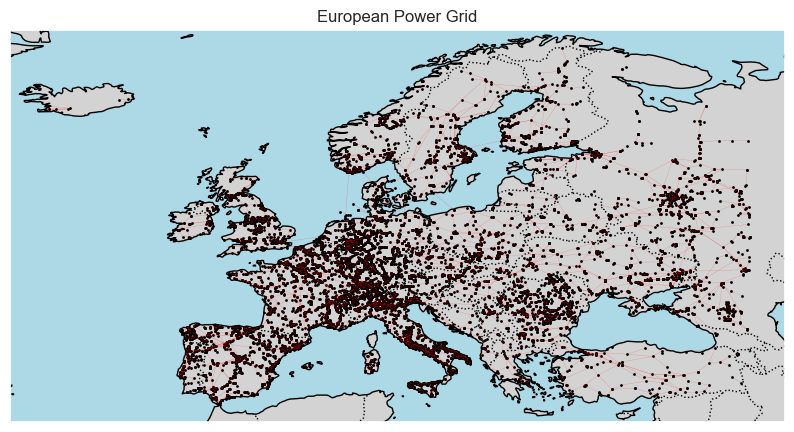

In [21]:
title="European Power Grid"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G.edges():
    x1, y1 = G.nodes[u]['pos']
    x2, y2 = G.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G.nodes(data=True)]
ys = [data['pos'][1] for _, data in G.nodes(data=True)]
ax.scatter(xs, ys, s=1, color='black', transform=ccrs.PlateCarree())

plt.show()


Visualizing the diferent types of stations

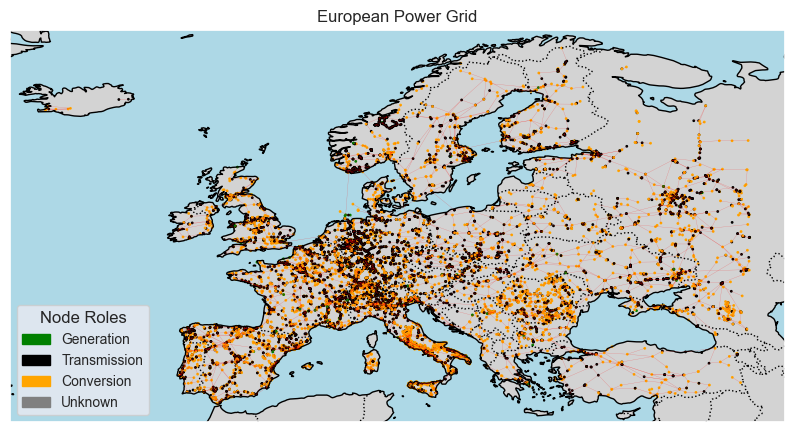

In [22]:
from matplotlib.patches import Patch

title="European Power Grid"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Preparing the colors
color_map = {
    "generation": "green",
    "transmission": "black",
    "conversion": "orange",
    "unknown": "gray"
}

colors = [color_map.get(data.get("role", "unknown"), "gray") for _, data in G.nodes(data=True)]



# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G.edges():
    x1, y1 = G.nodes[u]['pos']
    x2, y2 = G.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G.nodes(data=True)]
ys = [data['pos'][1] for _, data in G.nodes(data=True)]
ax.scatter(xs, ys, s=1, color=colors, transform=ccrs.PlateCarree())


# Create legend handles manually
legend_elements = [
    Patch(facecolor='green', edgecolor='green', label='Generation'),
    Patch(facecolor='black', edgecolor='black', label='Transmission'),
    Patch(facecolor='orange', edgecolor='orange', label='Conversion'),
    Patch(facecolor='gray', edgecolor='gray', label='Unknown'),
]

# Add the legend to the map
ax.legend(
    handles=legend_elements,
    loc='lower left',  # or 'upper right', etc.
    title='Node Roles',
    frameon=True,
    fontsize='small'
)

plt.show()


## 1st Analysis
### Graph Analysis

As our network is an infrastructure we expect some characteristics:

- Low average degree: Most nodes connect to 1-3 neighbours
- Low clustering coefficient: Few triangles, Infrastructure networks are "tree-like" for redundancy and cost reasons. This makes even more sense for an eletrical grid comparing for example with a highways network.
- High average path length: Long routes from one node to another due to physical/geographic constraints
- Degree distribuition: Exponential or truncated power law. Hubs exist, but extreme hubs (like in social networks) are rare due to physical/engineering limits
- Geographical: Layout respects geography, unlike abstract graphs like the internet 
- Robust yet fragile: Robust to random failure, fragile to targeted attacks (like hubs or plants)

In [23]:
def info(G):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max(k for _, k in G.degree())))
  
  C = sorted(nx.connected_components(G), key = len, reverse = True)

  print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

  if isinstance(G, nx.MultiGraph):
    G = nx.Graph(G)

  print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G)))
  print()
  
  return G


In [24]:
info(G)

       Graph | ''
       Nodes | 13,871 (27)
       Edges | 17,277 (0)
      Degree | 2.49 (16)
         LCC | 97.2% (86)
  Clustering | 0.0893



# Reducing to LCC

In [25]:
connected_components = list(nx.connected_components(G))

# Número de componentes conectados
num_connected_components = len(connected_components)
print("\nNumber of connected components:\n", num_connected_components)
# reducing to the largest connected component but keeping the result as a graph

G_reduced = G.subgraph(max(nx.connected_components(G), key=len))
print("\nNumber of nodes in the largest connected component:\n", len(G_reduced.nodes()))
print("\nNumber of edges in the largest connected component:\n", len(G_reduced.edges()))
# ratios compared with orginal graph
print("\nRatio of nodes in the largest connected component:\n", len(G_reduced.nodes())/len(G.nodes()))
print("\nRatio of edges in the largest connected component:\n", len(G_reduced.edges())/len(G.edges()))


Number of connected components:
 86

Number of nodes in the largest connected component:
 13478

Number of edges in the largest connected component:
 16922

Ratio of nodes in the largest connected component:
 0.971667507749982

Ratio of edges in the largest connected component:
 0.979452451235747


In [26]:
info(G_reduced)

       Graph | ''
       Nodes | 13,478 (0)
       Edges | 16,922 (0)
      Degree | 2.51 (16)
         LCC | 100.0% (1)
  Clustering | 0.0891



In [27]:
stations = set()
generation = 0
conversion = 0
transmission = 0
uk = 0
for _, i in G_reduced.nodes(data=True):
    typ = i.get('typ')
    role = i.get('role')
    if role == 'generation':
        generation += 1
    elif role == 'conversion':
        conversion += 1
    elif role == 'transmission':
        transmission += 1
    else:
        uk +=1
    stations.add(typ)
print("Types of stations: ", stations)
print("Number of generation stations: ", generation)
print("Number of conversion stations: ", conversion)
print("Number of transmission stations: ", transmission)
print("Unknown stations: ", uk)

Types of stations:  {'substation', 'joint', 'merge', 'plant', 'sub_station', 'station'}
Number of generation stations:  116
Number of conversion stations:  6162
Number of transmission stations:  7200
Unknown stations:  0


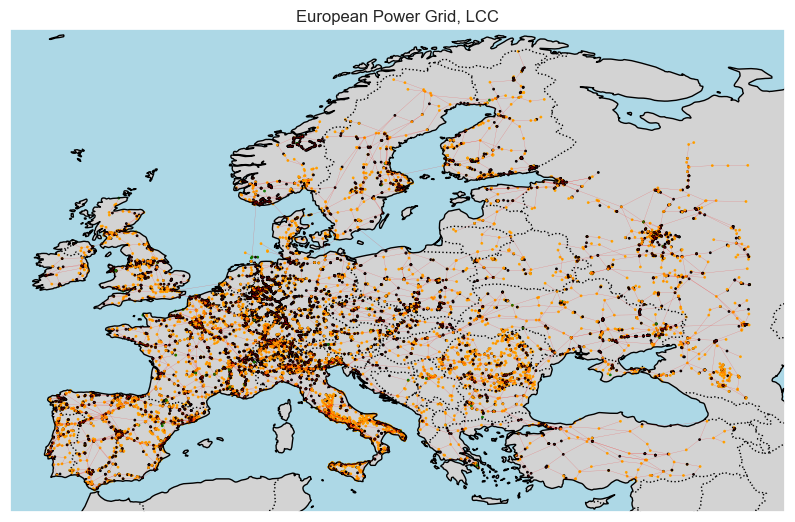

In [28]:
title="European Power Grid, LCC"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Preparing the colors
color_map = {
    "generation": "green",
    "transmission": "black",
    "conversion": "orange",
    "unknown": "gray"
}

colors = [color_map.get(data.get("role", "unknown"), "gray") for _, data in G_reduced.nodes(data=True)]



# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G_reduced.nodes(data=True)]
ys = [data['pos'][1] for _, data in G_reduced.nodes(data=True)]
ax.scatter(xs, ys, s=1, color=colors, transform=ccrs.PlateCarree())

plt.show()

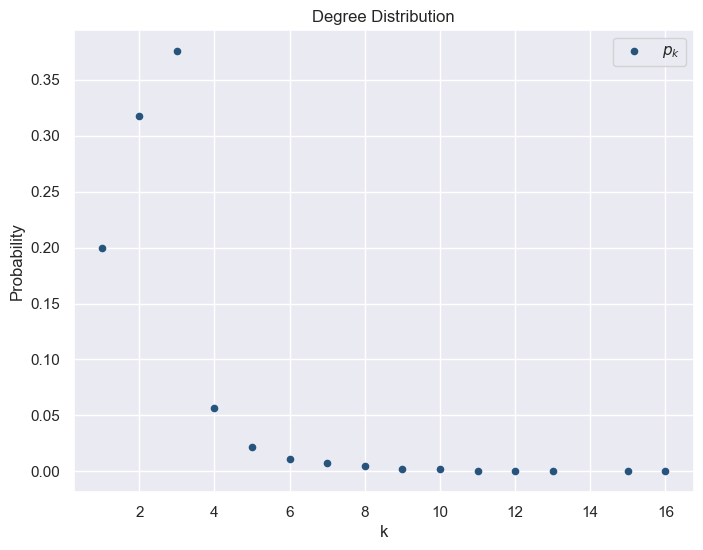

In [29]:
degree = np.array([d for _, d in G_reduced.degree()])
unique_degree, counts = np.unique(degree, return_counts=True)
degree_distribution = counts / counts.sum()

ball_size = 20

# plot
plt.figure(figsize=(8,6))
plt.scatter(unique_degree, degree_distribution, label=r"$p_{k}$", color='#26547C', s=ball_size)
plt.xlabel(r'k')
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.legend()
plt.show()

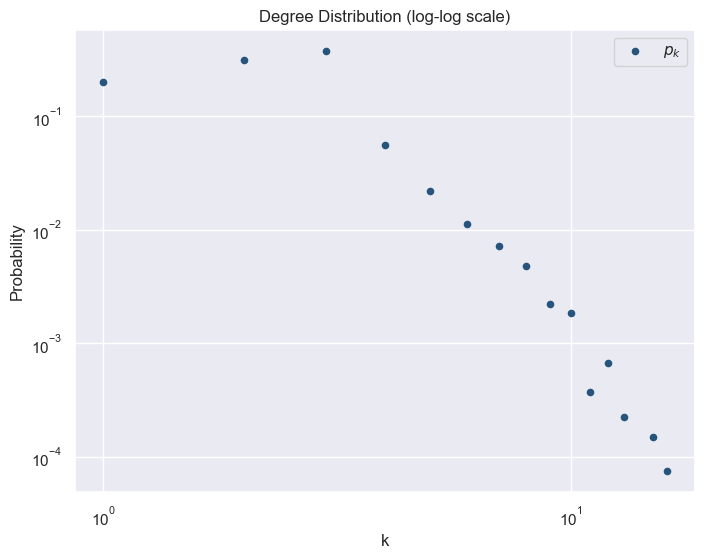

In [30]:

plt.figure(figsize=(8,6))
plt.scatter(unique_degree, degree_distribution, label=r"$p_{k}$", color='#26547C', s=ball_size)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'k')
plt.ylabel("Probability")
plt.title("Degree Distribution (log-log scale)")
plt.legend()
plt.show()

Assuming nested distributions


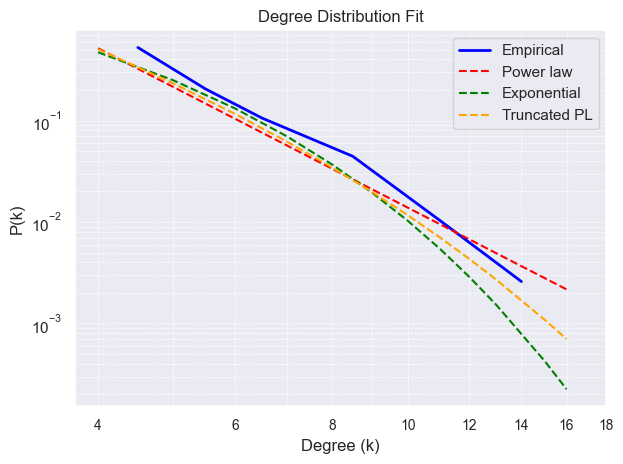

In [31]:
import powerlaw
import matplotlib.ticker as ticker

n = len(G_reduced.nodes())
counts = (degree_distribution * n).astype(int)

degree_sequence = []
for k, c in zip(unique_degree, counts):
    degree_sequence.extend([int(k)] * int(c))

# Fit a power-law distribution to the degree sequence
fit = powerlaw.Fit(degree_sequence, discrete=True, verbose=False)

# Compare power-law vs exponential
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')

# Compare power-law vs truncated power-law
R_trunc, p_trunc = fit.distribution_compare('power_law', 'truncated_power_law')

fig = fit.plot_pdf(color='blue', linewidth=2, label='Empirical')
fit.power_law.plot_pdf(color='red', linestyle='--', label='Power law')
fit.exponential.plot_pdf(color='green', linestyle='--', label='Exponential')
fit.truncated_power_law.plot_pdf(color='orange', linestyle='--', label='Truncated PL')

plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution Fit")

# Improved log-scale x-axis
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

# Set ticks manually (you can adjust these values to suit your data)
xticks = [ 4, 6,8, 10, 12,14, 16,18]
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='x', which='major', labelsize=10)

plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

With the fit to, we can show that the electricity grid network exhibits truncated power-law degree distribution ( typical of engineered systems with some emergent structure but strict constraints on node capacity)

In [32]:

def diameter(G):
    D = nx.single_source_shortest_path_length(G, max(G.degree, key = lambda item: item[1])[0])
    for _ in range(10):
        D = nx.single_source_shortest_path_length(G, max(D, key = D.get))
    return max(D.values())
G_diameter = diameter(G_reduced)
print("Graph diameter:", G_diameter)



Graph diameter: 147


### Centrality Measures

In [33]:
def pagerank(G, alpha = 0.85, eps=10e-3):
    P = np.array([1/len(G)]*len(G))
    diff = 1
    while diff > eps:
        U = np.zeros(len(G))

        for i in G.nodes():
            for j in G[i]: # for directed go trough predecessors
                U[i] = U[i] + P[j] * alpha / G.degree(j) # we want out degree. If we have weighted graph for each predecessor (neighbour) multiply by the weight and then divide by sum of weights instead of degree
        u = U.sum()

        for i in G.nodes(): 
            U[i] = U[i] + (1 - u) / len(G)
        
        diff = np.absolute(U - P).sum()

        P = U

    return {i : P[i] for i in G.nodes}

In [34]:
from geopy.geocoders import Nominatim
import time

geocache = {}
geolocator = Nominatim(user_agent="grid-centrality-analyzer")

def reverse_geocode(lat, lon):
    key = (lat, lon)
    if key in geocache:
        return geocache[key]
    try:
        location = geolocator.reverse((lat, lon), language='en', timeout=10)
        result = location.address if location else "Unknown"
    except Exception as e:
        result = f"Error: {e}"
    geocache[key] = result
    return result

# Helper function to print top nodes
def top_nodes(cent_dict, name, n=5, with_geo=True):
    print(f"\nTop {n} nodes by {name}:")
    for node, score in sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:n]:
        pos = G_reduced.nodes[node].get("pos", (None, None))
        lat, lon = pos[1], pos[0]
        if with_geo and lat is not None and lon is not None:
            address = reverse_geocode(lat, lon)
            print(f"Node {node}: {score:.4f}  @ ({lat:.4f}, {lon:.4f}) → {address}")
            time.sleep(1)
        else:
            print(f"Node {node}: {score:.4f}  @ ({lat:.4f}, {lon:.4f})")

# Degree Centrality 
print("Computing Degree Centrality...")
deg_cent = nx.degree_centrality(G_reduced)
top_nodes(deg_cent, "Degree Centrality")
print("============================================================\n")
# Betweenness Centrality
print("Computing Betweenness Centrality...")
btw_cent = nx.betweenness_centrality(G_reduced, normalized=True)
top_nodes(btw_cent, "Betweenness Centrality")
print("============================================================\n")
# Closeness Centrality
print("Computing Closeness Centrality...")
clo_cent = nx.closeness_centrality(G_reduced)
top_nodes(clo_cent, "Closeness Centrality")
print("============================================================\n")

# PageRank 
print("Computing PageRank Centrality...")
prank_cent = nx.pagerank(G_reduced)
top_nodes(prank_cent, "PageRank Centrality")
print("============================================================\n")

# Edge Betweenness Centrality 
print("Computing Edge Betweenness Centrality...")
edge_btw = nx.edge_betweenness_centrality(G_reduced, normalized=True)
top_edges = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 edges by betweenness centrality, nodes it connects:")
for (u, v), score in top_edges:
    print(f"  {u} <--> {v}: {score:.5f}")
print("============================================================\n")

Computing Degree Centrality...

Top 5 nodes by Degree Centrality:
Node 39665: 0.0012  @ (49.0339, 2.4329) → D 10, Le Plessis-Gassot, Sarcelles, Val-d'Oise, Ile-de-France, Metropolitan France, 95720, France
Node 20288: 0.0011  @ (44.7793, 2.6893) → Rueyres, Brommat, Rodez, Aveyron, Occitania, Metropolitan France, 12600, France
Node 54561: 0.0011  @ (48.3893, 2.8668) → Rue de la Grande Paroisse, Le Chesnoy, Vernou-sur-Seine, Vernou-la-Celle-sur-Seine, Fontainebleau, Seine-et-Marne, Ile-de-France, Metropolitan France, 77670, France
Node 20281: 0.0010  @ (46.0560, 5.8048) → 17, Rue des Fontaines, En Balavent, Génissiat, Injoux-Génissiat, Nantua, Ain, Auvergne-Rhône-Alpes, Metropolitan France, 01200, France
Node 54279: 0.0010  @ (41.7894, -4.9376) → VP-4509, El Carrascalejo, La Mudarra, Valladolid, Castile and León, Spain

Computing Betweenness Centrality...

Top 5 nodes by Betweenness Centrality:
Node 54736: 0.2756  @ (45.8523, 13.4717) → Via Venticinque Aprile, San Pier d'Isonzo, Gorizia,

In [35]:
nx.set_node_attributes(G_reduced, deg_cent, 'deg_cent')
nx.set_node_attributes(G_reduced, btw_cent, 'btw_cent')
nx.set_node_attributes(G_reduced, clo_cent, 'clo_cent')
nx.set_node_attributes(G_reduced, prank_cent, 'prank_cent')

In [47]:
import pickle

# Save results
with open("centralities.pkl", "wb") as f:
    pickle.dump({
        "deg_cent": deg_cent,
        "btw_cent": btw_cent,
        "clo_cent": clo_cent,
        "prank_cent": prank_cent,
        "edge_btw": edge_btw,
        "geocache": geocache,
    }, f)

# Use this to load them
# with open("centralities.pkl", "rb") as f:
#     data = pickle.load(f)
# deg_cent = data["deg_cent"]
# btw_cent = data["btw_cent"]
# clo_cent = data["clo_cent"]
# prank_cent = data["prank_cent"]
# edge_btw = data["edge_btw"]
# geocache = data["geocache"]

## Plots for Centrality Measures

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

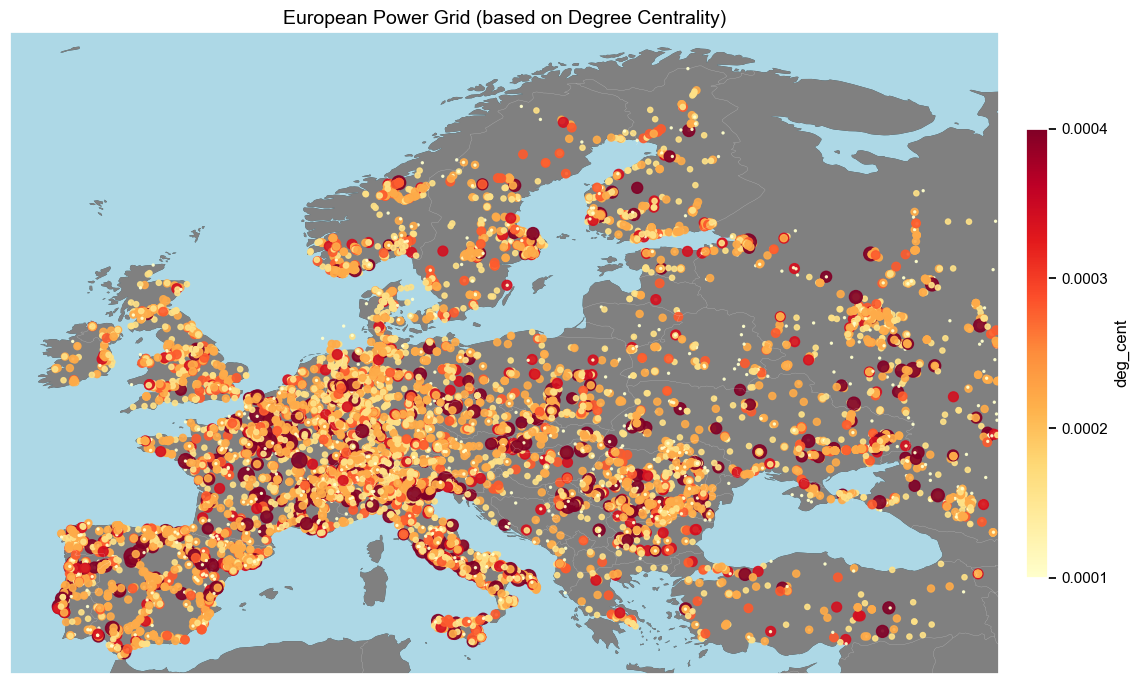

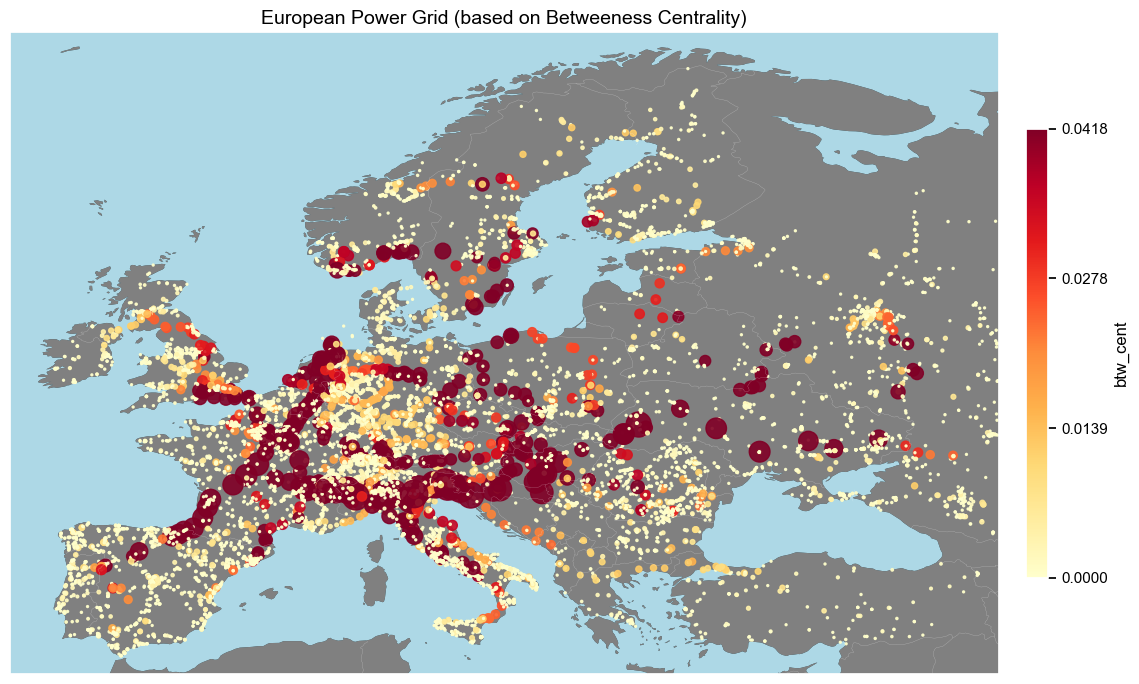

/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


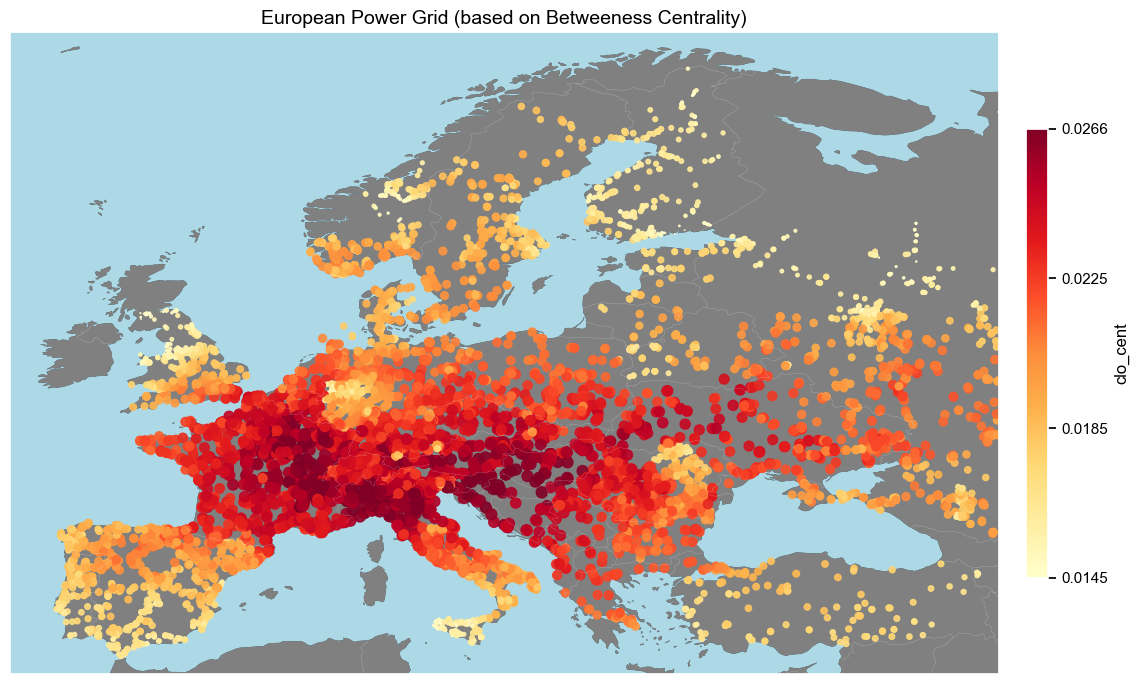

/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/envs/sqlalchemy_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


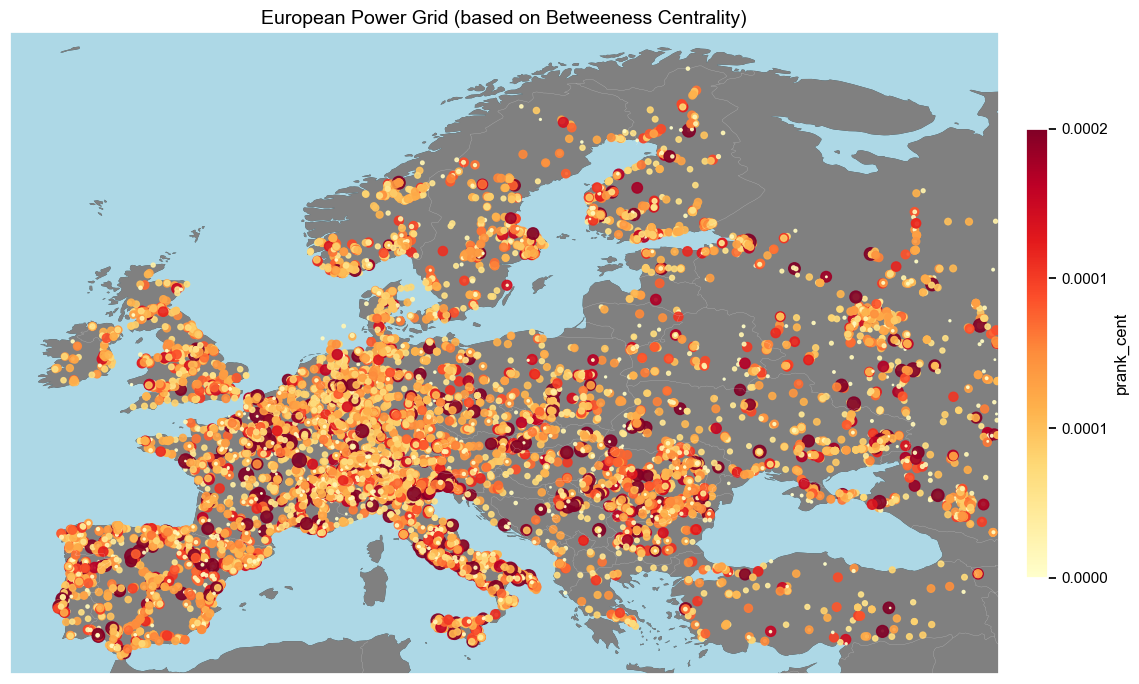

In [ ]:
def plot_centrality_map(G, centrality_key='btw_cent', title='Centrality Map', cmap='YlOrRd', topk=5):
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import matplotlib.colors as mcolors
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    xs, ys, colors, sizes = [], [], [], []
    cent_values = [data.get(centrality_key, 0) for _, data in G.nodes(data=True)]
    min_c, max_c = np.percentile(cent_values, 2), np.percentile(cent_values, 98)
    norm = mcolors.Normalize(vmin=min_c, vmax=max_c)
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)

    for _, data in G.nodes(data=True):
        x, y = data['pos']
        c = data.get(centrality_key, 0)
        xs.append(x)
        ys.append(y)
        colors.append(smap.to_rgba(c))
        sizes.append(2 + 60 * norm(c))

    fig = plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='gray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2, alpha=0.5)
    ax.set_extent([-12, 45, 35, 72], crs=ccrs.PlateCarree())
    ax.set_title(title, color="black", fontsize=14)
    ax.set_facecolor("black")

    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.9, transform=ccrs.PlateCarree())

    # # Highlight and annotate top-k nodes
    # if topk > 0:
    #     top_nodes = sorted(zip(G.nodes, cent_values), key=lambda x: x[1], reverse=True)[:topk]
    #     for rank, (n, _) in enumerate(top_nodes, 1):
    #         x, y = G.nodes[n]['pos']
    #         ax.scatter(x, y, s=80, color='white', edgecolor='red', linewidth=0.6, zorder=5, transform=ccrs.PlateCarree())
    #         ax.text(x + 0.5, y + 0.5, f"#{rank}", color='white', fontsize=9, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(smap, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
    cbar.set_label(centrality_key, color='black')
    ticks = np.linspace(min_c, max_c, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.4f}" for tick in ticks])
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
    
    plt.tight_layout()
    plt.show()

plot_centrality_map(G_reduced, centrality_key='deg_cent', title='European Power Grid (based on Degree Centrality)', cmap='YlOrRd', topk=5)
plot_centrality_map(G_reduced, centrality_key='btw_cent', title='European Power Grid (based on Betweeness Centrality)', cmap='YlOrRd', topk=5)
plot_centrality_map(G_reduced, centrality_key='clo_cent', title='European Power Grid (based on Closeness Centrality)', cmap='YlOrRd', topk=5)
plot_centrality_map(G_reduced, centrality_key='prank_cent', title='European Power Grid (based on Page Rank Centrality)', cmap='YlOrRd', topk=5)

In [39]:
nx.set_edge_attributes(G_reduced, edge_btw, "edge_btw")


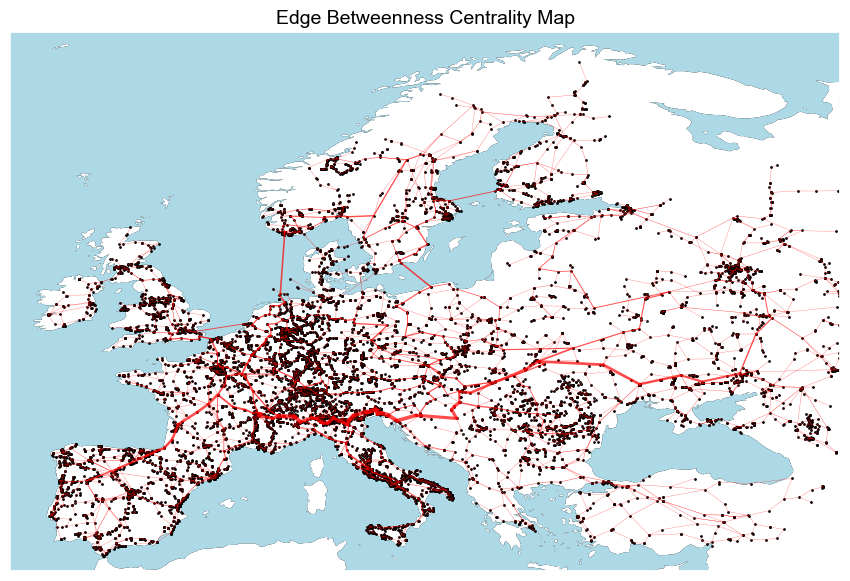

In [46]:
def plot_edge_betweenness_map(G, title='Edge Betweenness Centrality Map'):

    fig = plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2, alpha=0.5)
    ax.set_extent([-12, 45, 35, 72], crs=ccrs.PlateCarree())
    ax.set_title(title, color="black", fontsize=14)
    ax.set_facecolor("black")
    
    # Normalize edge centrality values
    edge_centralities = [G[u][v].get("edge_btw", 0) for u, v in G.edges()]
    min_c = min(edge_centralities)
    max_c = max(edge_centralities)
    edge_range = max_c - min_c if max_c > min_c else 1e-6

    for u, v in G.edges():
        x1, y1 = G.nodes[u]['pos']
        x2, y2 = G.nodes[v]['pos']
        c = G[u][v].get("edge_btw", 0)
        lw = 0.2 + 3 * (c - min_c) / edge_range  # scale from 0.2 to ~3.2
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=lw, alpha=0.7, transform=ccrs.Geodetic())

    # Draw nodes
    xs = [data['pos'][0] for _, data in G.nodes(data=True)]
    ys = [data['pos'][1] for _, data in G.nodes(data=True)]
    ax.scatter(xs, ys, s=1, color='black', transform=ccrs.PlateCarree())

    plt.show()

plot_edge_betweenness_map(G_reduced)

### Attacks

In [41]:
def simulate_node_attacks_lcc(G, strategies, steps=100, role=None):
    """
    Simulates node removals based on centrality strategies.
    Returns fraction of nodes in the Largest Connected Component (LCC) after each removal.
    """
    results = {}

    for strategy_name, scores in strategies.items():
        G_copy = G.copy()

        if strategy_name == 'random':
            node_pool = [n for n in G_copy.nodes() if (role is None or G_copy.nodes[n].get('role') == role)]
            random.shuffle(node_pool)
            node_order = node_pool
        else:
            filtered_scores = {n: s for n, s in scores.items() if (role is None or G.nodes[n].get('role') == role)}
            node_order = [n for n, _ in sorted(filtered_scores.items(), key=lambda x: x[1], reverse=True)]

        lcc_fractions = []
        original_node_count = G_copy.number_of_nodes()

        for i in range(min(steps, len(node_order))):
            G_copy.remove_node(node_order[i])
            if G_copy.number_of_nodes() == 0:
                lcc_fractions.append(0)
                continue
            # size of largest connected component
            lcc = max(nx.connected_components(G_copy), key=len)
            lcc_fraction = len(lcc) / original_node_count
            lcc_fractions.append(lcc_fraction)

        results[strategy_name] = lcc_fractions

    return results

def plot_attack_simulation_lcc_percent(results, G, role=None, xlim=0.2):
    plt.figure(figsize=(10, 6))
    total_nodes = None
    if role is None:
        total_nodes = G.number_of_nodes()
    else:
        total_nodes = sum(1 for _, data in G.nodes(data=True) if data.get('role') == role)

    for name, lcc_fracs in results.items():
        x_vals = [(i + 1) / total_nodes for i in range(len(lcc_fracs))]
        plt.plot(x_vals, lcc_fracs, label=name)

    plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50% LCC remaining')
    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Fraction of nodes in Largest Connected Component (LCC)")
    plt.xlim(0, xlim)  # fixed x-axis limit for comparability
    plt.ylim(0, 1)
    if role:
        plt.title(f"Network Resilience Under Node Attacks (role: {role})")
    else:
        plt.title("Network Resilience Under Node Attacks")
    plt.legend()
    plt.grid(True)
    plt.show()





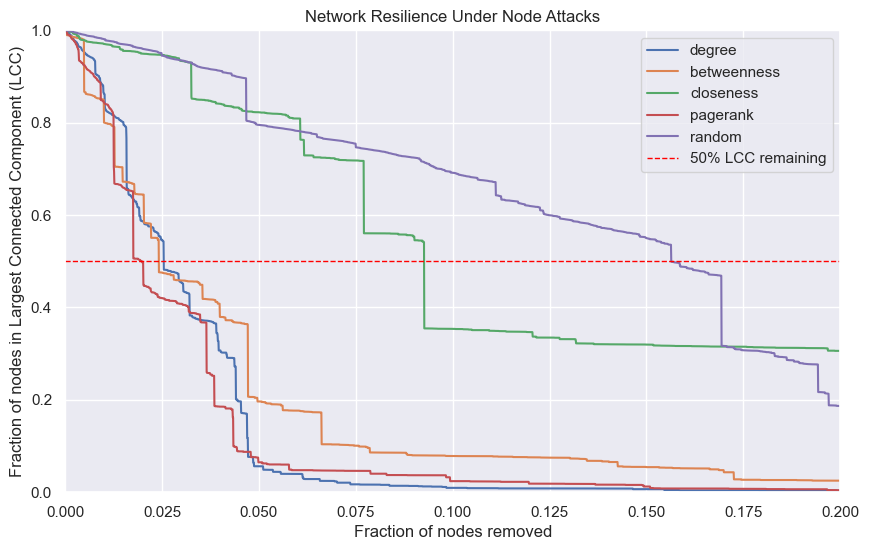

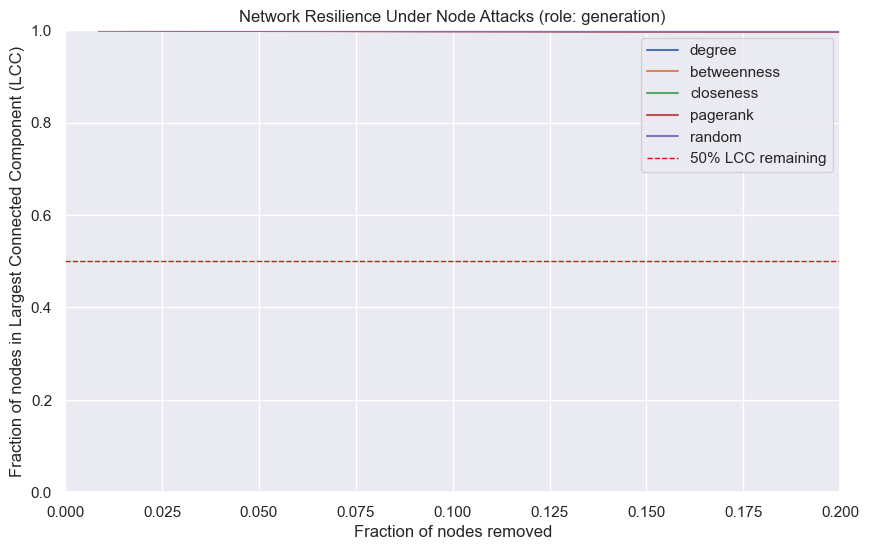

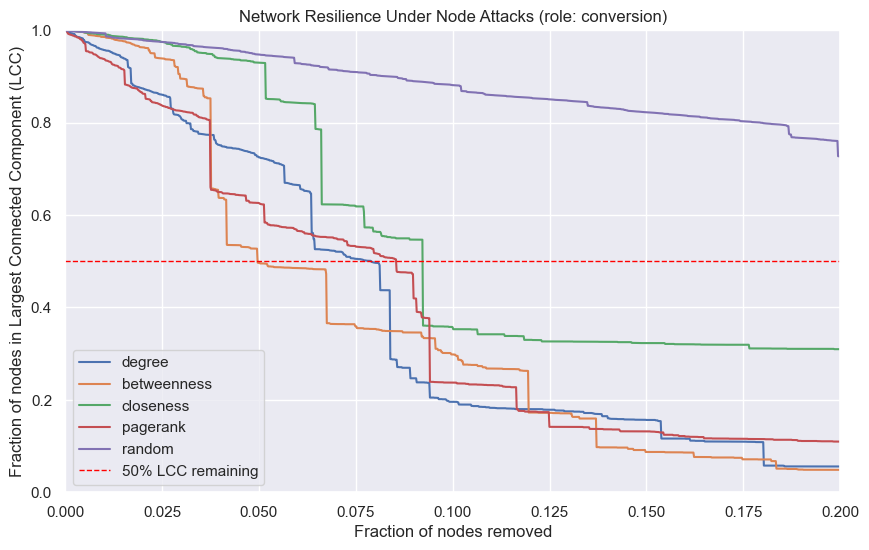

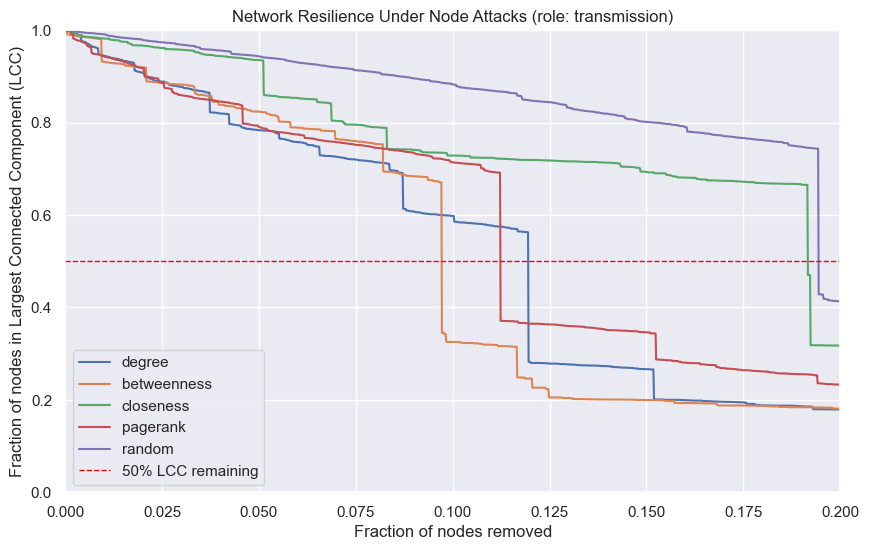

In [42]:
centrality_strategies = {
    'degree': deg_cent,
    'betweenness': btw_cent,
    'closeness': clo_cent,
    'pagerank': prank_cent,
    'random': {} 
}
max_fraction = 0.2  
perc = int(max_fraction * len(G_reduced.nodes()))


results = simulate_node_attacks_lcc(G_reduced, centrality_strategies, role=None, steps=perc)
plot_attack_simulation_lcc_percent(results, G_reduced, role=None, xlim=max_fraction)

results_generation = simulate_node_attacks_lcc(G_reduced, centrality_strategies, role='generation', steps=perc)
plot_attack_simulation_lcc_percent(results_generation, G_reduced, role='generation', xlim=max_fraction)

results_conversion = simulate_node_attacks_lcc(G_reduced, centrality_strategies, role='conversion', steps=perc)
plot_attack_simulation_lcc_percent(results_conversion, G_reduced, role='conversion', xlim=max_fraction)

results_transmission = simulate_node_attacks_lcc(G_reduced, centrality_strategies, role='transmission', steps=perc)
plot_attack_simulation_lcc_percent(results_transmission, G_reduced, role='transmission', xlim=max_fraction)


Edge attack

In [48]:
def simulate_edge_attacks_lcc(G, strategies, steps=100):
    """
    Simulates edge removals based on different centrality strategies.
    Returns fraction of nodes in Largest Connected Component (LCC) after each removal.
    """
    results = {}

    total_edges = G.number_of_edges()
    original_node_count = G.number_of_nodes()

    for strategy_name, scores in strategies.items():
        G_copy = G.copy()
        if strategy_name == 'random':
            edge_order = list(G_copy.edges())
            random.shuffle(edge_order)
        else:
            edge_order = [e for e, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]

        lcc_fractions = []

        for i in range(min(steps, len(edge_order))):
            u, v = edge_order[i]
            if G_copy.has_edge(u, v):
                G_copy.remove_edge(u, v)

            if G_copy.number_of_nodes() == 0:
                lcc_fractions.append(0)
                continue

            # Compute size of largest connected component
            lcc = max(nx.connected_components(G_copy), key=len)
            lcc_fraction = len(lcc) / original_node_count
            lcc_fractions.append(lcc_fraction)

        results[strategy_name] = lcc_fractions

    return results


def plot_edge_attack_simulation_lcc_percent(results, G):
    plt.figure(figsize=(10, 6))
    total_edges = G.number_of_edges()

    for name, lcc_fracs in results.items():
        x_vals = [(i + 1) / total_edges for i in range(len(lcc_fracs))]  # fraction of edges removed
        plt.plot(x_vals, lcc_fracs, label=name)

    plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50% LCC remaining')

    plt.xlabel("Fraction of edges removed")
    plt.ylabel("Fraction of nodes in Largest Connected Component (LCC)")
    plt.xlim(0, max(x_vals))
    plt.ylim(0, 1)
    plt.title("Network Resilience Under Edge Attacks")
    plt.legend()
    plt.grid(True)
    plt.show()


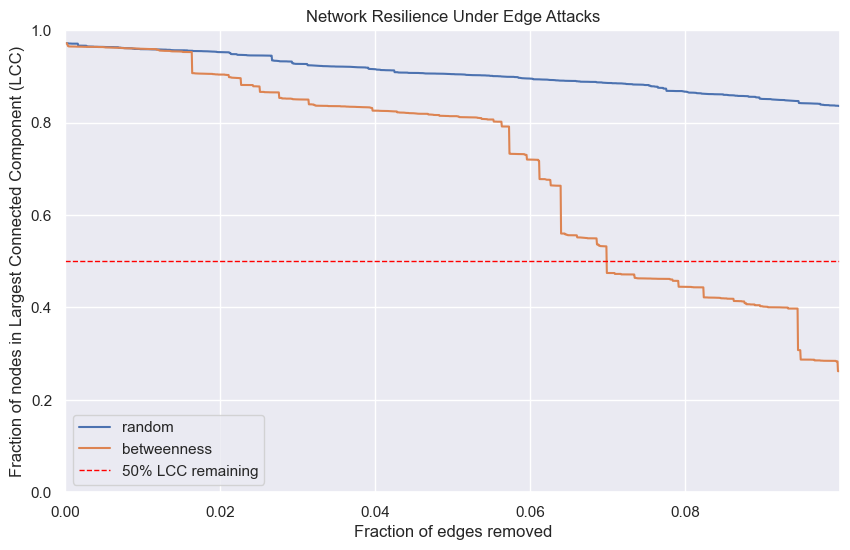

In [49]:
edge_centrality_strategies = {
    'random': {},
    'betweenness': edge_btw 
}

steps = int(0.1 * G.number_of_edges()) 

results_edge = simulate_edge_attacks_lcc(G, edge_centrality_strategies, steps=steps)
plot_edge_attack_simulation_lcc_percent(results_edge, G)

## 2nd Analysis

The main difference of this analysis is that when attacking we will evaluate the number of nodes that still have eletricity basically. For this one I think we can also make some plots were we showcase the light and dark zones 

In [50]:
# This is the funtion to determine if a node has eletricity
def has_electricity(G, generators, node):
    """
    Returns True if the node is a generator or is connected to at least one generator.
    """
    if node not in G:
        return False  # node doesn't exist

    if G.nodes[node].get('role') == 'generation':
        return True

    # Check if there's a path from node to any generator
    for gen in generators:
        if nx.has_path(G, source=node, target=gen):
            return True

    return False

# def get_powered_nodes(G, generators):
#     """
#     Returns a set of all nodes that have a path to at least one generator.
#     This includes the generators themselves.
#     """
#     powered = set()
#     for gen in generators:
#         if gen not in G:
#             continue
#         reachable = nx.single_source_shortest_path_length(G, gen).keys()
#         powered.update(reachable)
#     return powered

def get_powered_nodes(G, generators):
    """
    Returns set of nodes reachable from any generator.
    Performs a multi-source BFS from all generators simultaneously.
    """
    powered = set()
    if not generators:
        return powered

    visited = set()
    queue = list(generators)

    while queue:
        current = queue.pop(0)
        if current in visited:
            continue
        visited.add(current)
        powered.add(current)
        neighbors = G.neighbors(current)
        for nbr in neighbors:
            if nbr not in visited:
                queue.append(nbr)

    return powered




# to use we generate the generators like this:
generators = {n for n, d in G.nodes(data=True) if d.get('role') == 'generation' and n in G}
# this happens because we will remove nodes and if they are a generator the list will change


In [ ]:
def simulate_node_attacks_with_power(G, strategies, steps=100, role=None):
    """
    Simulates node removals based on centrality strategies.
    Returns dict of lists for LCC fraction and powered fraction after each removal.
    """
    results = {}

    original_node_count = G.number_of_nodes()

    for strategy_name, scores in strategies.items():
        G_copy = G.copy()
        lcc_fractions = []
        powered_fractions = []

        # Get initial generators in the graph
        generators = {n for n, d in G_copy.nodes(data=True) if d.get('role') == 'generation'}

        if strategy_name == 'random':
            node_pool = [n for n in G_copy.nodes() if (role is None or G_copy.nodes[n].get('role') == role)]
            random.shuffle(node_pool)
            node_order = node_pool
        else:
            filtered_scores = {n: s for n, s in scores.items() if (role is None or G.nodes[n].get('role') == role)}
            node_order = [n for n, _ in sorted(filtered_scores.items(), key=lambda x: x[1], reverse=True)]

        for i in range(min(steps, len(node_order))):
            G_copy.remove_node(node_order[i])

            # Update generators set if generator removed
            generators = {n for n, d in G_copy.nodes(data=True) if d.get('role') == 'generation'}

            if G_copy.number_of_nodes() == 0:
                lcc_fractions.append(0)
                powered_fractions.append(0)
                continue

            # Compute LCC fraction
            lcc = max(nx.connected_components(G_copy), key=len)
            lcc_fraction = len(lcc) / original_node_count
            lcc_fractions.append(lcc_fraction)

            # Compute powered fraction
            powered_nodes = get_powered_nodes(G_copy, generators)
            powered_fraction = len(powered_nodes) / original_node_count
            powered_fractions.append(powered_fraction)

        results[strategy_name] = {
            'lcc': lcc_fractions,
            'powered': powered_fractions
        }

    return results

import itertools

def plot_resilience_comparison(results, G, role=None, xlim=0.2):
    plt.figure(figsize=(12, 6))

    total_nodes = G.number_of_nodes() if role is None else sum(
        1 for _, d in G.nodes(data=True) if d.get('role') == role
    )

    color_cycle = itertools.cycle(plt.cm.tab10.colors)  
    strategy_colors = {}

    for strategy_name in results:
        strategy_colors[strategy_name] = next(color_cycle)

    for strategy_name, data in results.items():
        x_vals = [(i + 1) / total_nodes for i in range(len(data['lcc']))]
        color = strategy_colors[strategy_name]

        plt.plot(x_vals, data['lcc'], label=f"{strategy_name} - LCC", linestyle='-', color=color)
        plt.plot(x_vals, data['powered'], label=f"{strategy_name} - Powered", linestyle='--', color=color)

    plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50% threshold')

    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Fraction")
    plt.xlim(0, xlim)
    plt.ylim(0, 1)
    plt.title(f"Network Resilience: LCC vs. Power Availability {role if role else ''}")
    plt.legend()
    plt.grid(True)
    plt.show()



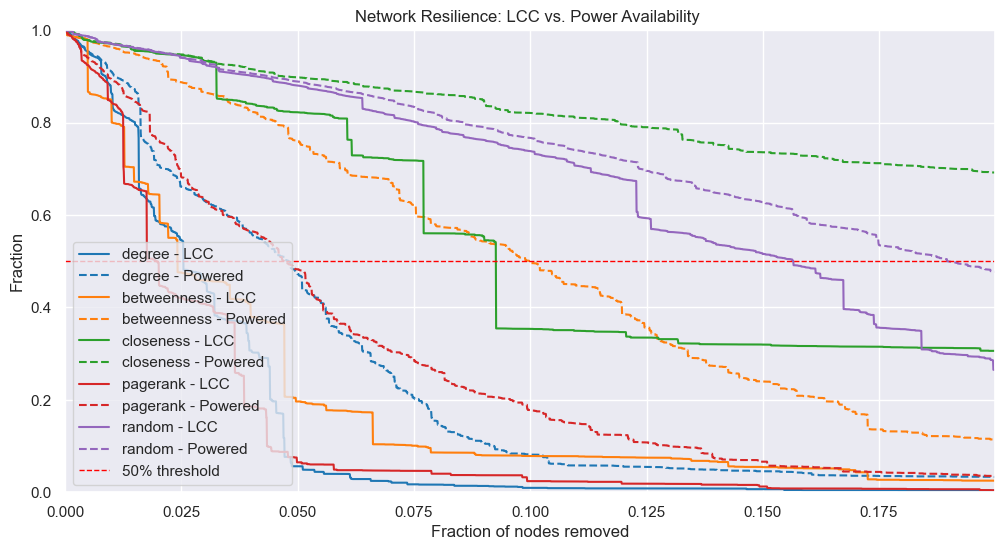

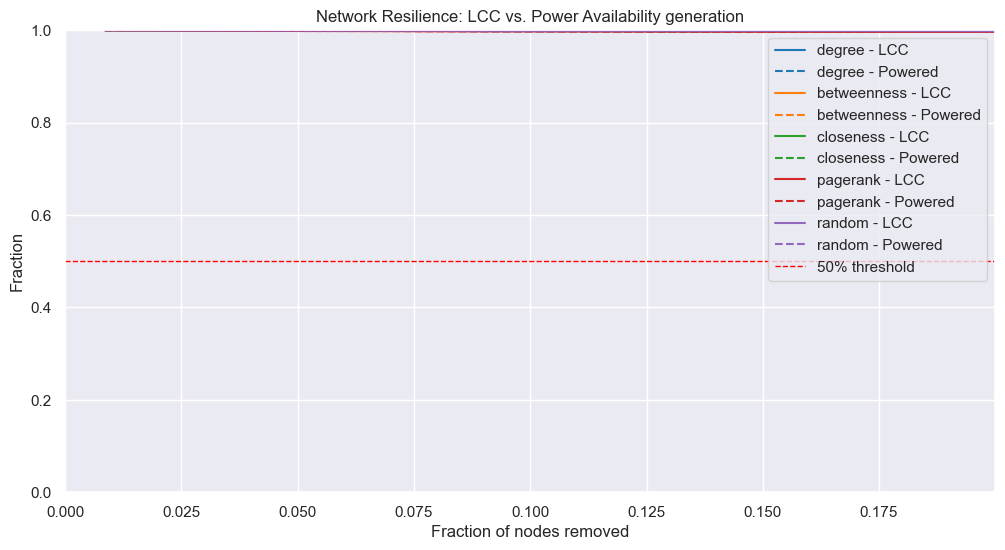

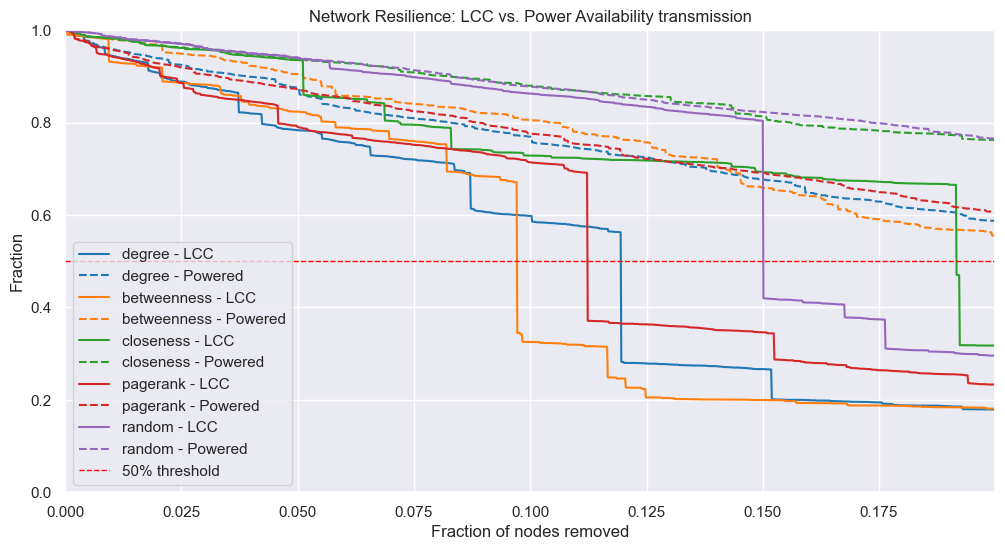

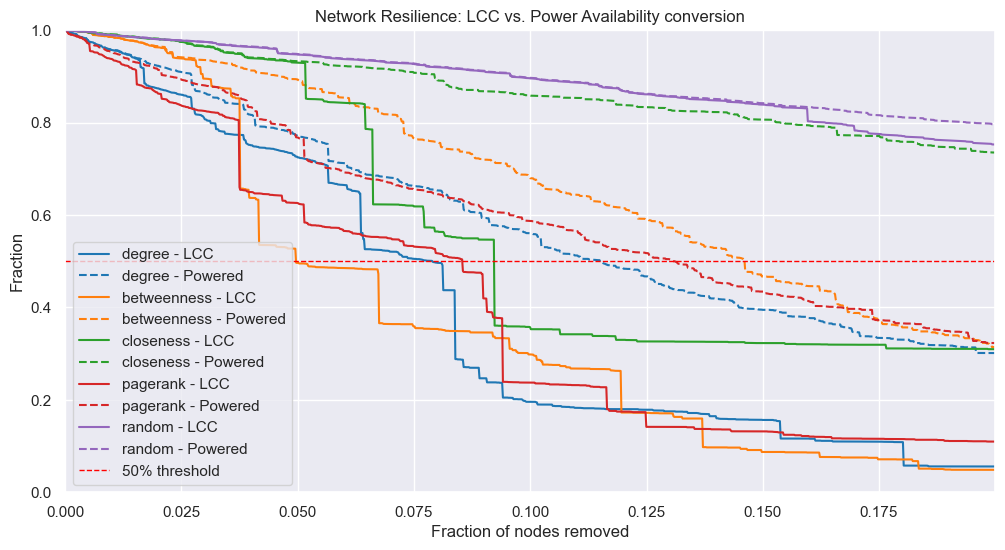

In [53]:


perc = int(0.2 * G_reduced.number_of_nodes())  
results = simulate_node_attacks_with_power(G_reduced, centrality_strategies, steps=perc, role=None)
plot_resilience_comparison(results, G_reduced, role=None, xlim=perc / G_reduced.number_of_nodes())

results_generation = simulate_node_attacks_with_power(G_reduced, centrality_strategies, steps=perc, role='generation')
plot_resilience_comparison(results_generation, G_reduced, role='generation', xlim=perc / G_reduced.number_of_nodes())

results_transmission = simulate_node_attacks_with_power(G_reduced, centrality_strategies, steps=perc, role='transmission')
plot_resilience_comparison(results_transmission, G_reduced, role='transmission', xlim=perc / G_reduced.number_of_nodes())

results_conversion = simulate_node_attacks_with_power(G_reduced, centrality_strategies, steps=perc, role='conversion')
plot_resilience_comparison(results_conversion, G_reduced, role='conversion', xlim=perc / G_reduced.number_of_nodes())


# Iberian Peninsula Attack Simulation

In 2025, the Iberian Peninsula experienced a major power outage triggered by synchronization issues and the disconnection of power flows from France, a critical neighboring grid. Our analysis showed that all cross-border transmission lines connecting the Iberian Peninsula to the outside network come from France, making France a clear bottleneck for the region's electricity supply.

To understand the impact, we first simulated failure by removing all generator nodes within the Iberian Peninsula and examined how power availability was affected locally (was removed by degree).

Then, we simulated the additional effect of cutting off all transmission edges connecting France to Iberian Peninsula, mimicking the real-life loss of cross-border supply.


In [ ]:
def filter_iberian_peninsula(G):
    nodes_in_iberia = [
        n for n, data in G.nodes(data=True)
        if 'pos' in data and 
           -10 <= data['pos'][0] <= 5 and 
           35 <= data['pos'][1] <= 45
    ]
    return G.subgraph(nodes_in_iberia).copy()

G_iberia = filter_iberian_peninsula(G_reduced)
# Remove all generators to simulate worst-case
generators_iberia = [n for n, d in G_reduced.nodes(data=True) if d.get('role') == 'generation']

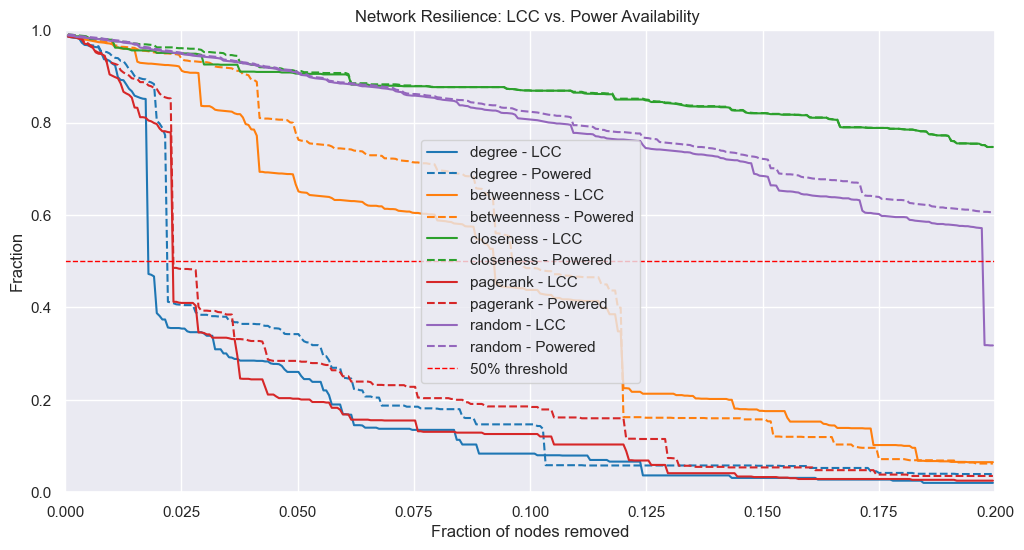

In [64]:
deg_cent_iberia = {n: deg_cent[n] for n in G_iberia.nodes()}
btw_cent_iberia = {n: btw_cent[n] for n in G_iberia.nodes()}
clo_cent_iberia = {n: clo_cent[n] for n in G_iberia.nodes()}
prank_cent_iberia = {n: prank_cent[n] for n in G_iberia.nodes()}

centrality_strategies_iberia = {
    'degree': deg_cent_iberia,
    'betweenness': btw_cent_iberia,
    'closeness': clo_cent_iberia,
    'pagerank': prank_cent_iberia,
    'random': {}
}

steps = int(0.2 * G_iberia.number_of_nodes()) 

results_iberia = simulate_node_attacks_with_power(G_iberia, centrality_strategies_iberia, steps=steps)
plot_resilience_comparison(results_iberia, G_iberia, xlim=0.2)

In [ ]:
#Degree based removal works the best

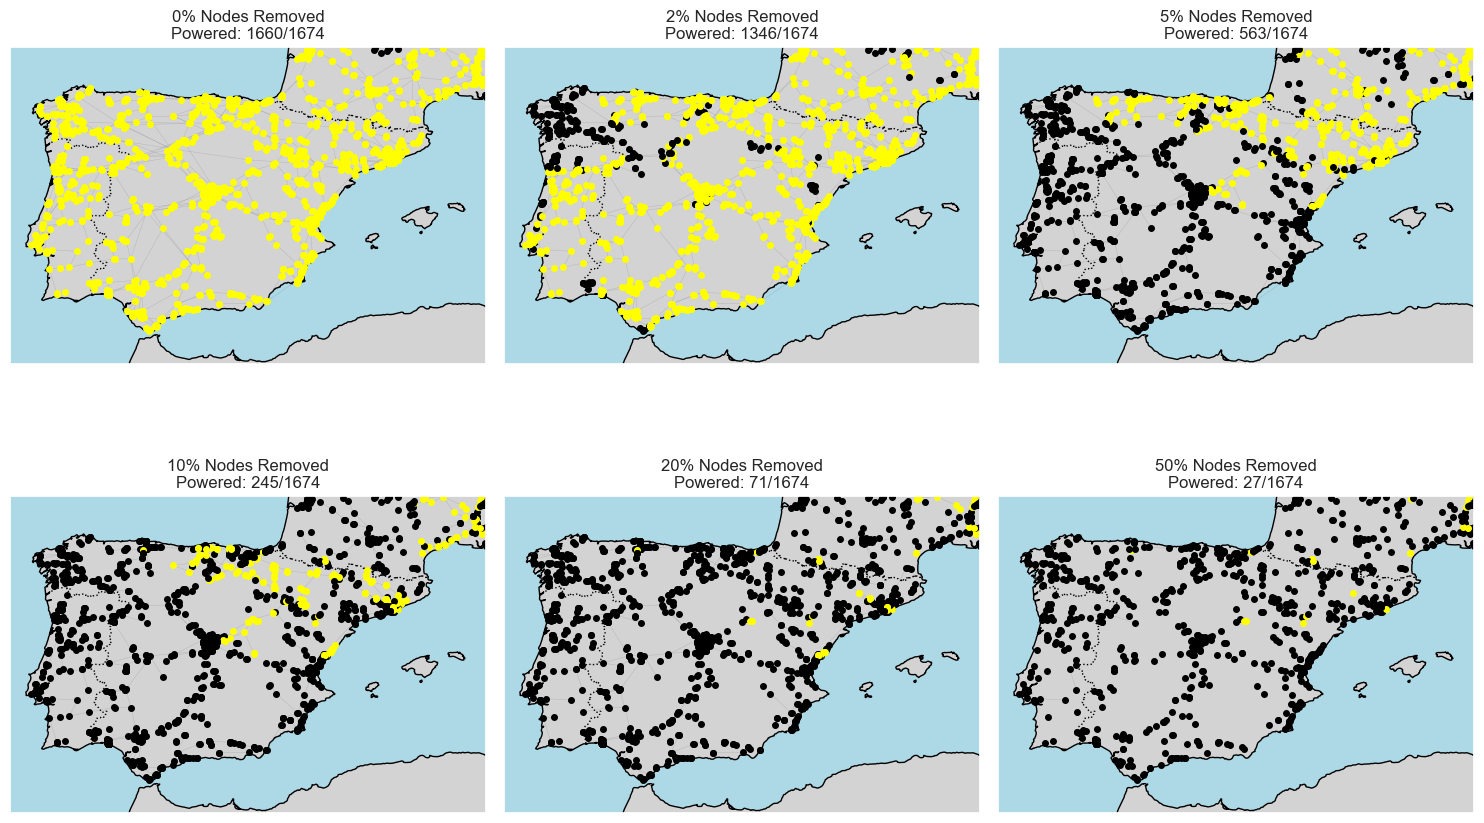

In [ ]:
def plot_power_availability_progressive_removal(G, generators, removal_percents, role=None):
    """
    Plot power availability maps with progressive removal of nodes (by role or any nodes).
    
    removal_percents: list of fractions (0 to 1) of nodes to remove progressively.
    """
    total_nodes = G.number_of_nodes() if role is None else sum(1 for _, d in G.nodes(data=True) if d.get('role') == role)
    
    # Get list of nodes to consider for removal (all nodes or filtered by role)
    nodes_to_remove = [n for n, d in G.nodes(data=True) if (role is None or d.get('role') == role)]
    
    # Sort nodes by degree descending for removal order (or any other strategy)
    nodes_sorted = sorted(nodes_to_remove, key=lambda n: G.degree(n), reverse=True)

    # Prepare subplots
    n_plots = len(removal_percents)
    ncols = min(3, n_plots)
    nrows = (n_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
    if n_plots == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, perc in enumerate(removal_percents):
        G_copy = G.copy()
        num_to_remove = int(perc * total_nodes)
        remove_nodes = nodes_sorted[:num_to_remove]
        G_copy.remove_nodes_from(remove_nodes)
        
        # Update generators in subgraph
        generators_new = {n for n, d in G_copy.nodes(data=True) if d.get('role') == 'generation'}
        
        powered_nodes = get_powered_nodes(G_copy, generators_new)
        
        # Plot on the corresponding axis
        ax = axs[i]
        ax.set_title(f"{int(perc*100)}% Nodes Removed\nPowered: {len(powered_nodes)}/{total_nodes}")
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
        
        # Plot edges
        for u, v in G_copy.edges():
            x1, y1 = G_copy.nodes[u]['pos']
            x2, y2 = G_copy.nodes[v]['pos']
            ax.plot([x1, x2], [y1, y2], color='gray', linewidth=0.4, alpha=0.3, transform=ccrs.Geodetic())
        
        # Plot nodes
        for n in G_copy.nodes():
            x, y = G_copy.nodes[n]['pos']
            color = 'yellow' if n in powered_nodes else 'black'
            ax.plot(x, y, 'o', color=color, markersize=4, transform=ccrs.PlateCarree())

    # Hide any extra subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


removal_percents = [0, 0.02, 0.05, 0.10, 0.20, 0.50]  
plot_power_availability_progressive_removal(G_iberia, generators_iberia, removal_percents)

### Removing Connections from France

In [ ]:
def in_iberia(lat, lon):
    """Check if coordinates are within Iberian Peninsula bounds."""
    return 35 <= lat <= 45 and -10 <= lon <= 5

def in_france(lat, lon):
    """Check if coordinates are within France bounds."""
    return 41 <= lat <= 51 and -5 <= lon <= 9


iberia_nodes = set()
france_nodes = set()

for node, data in G_reduced.nodes(data=True):
    pos = data.get('pos')
    if not pos:
        continue
    lon, lat = pos  # pos is (lon, lat)
    if in_iberia(lat, lon):
        iberia_nodes.add(node)
    elif in_france(lat, lon):
        france_nodes.add(node)

# --- Extract all generators from the full graph ---
all_generators = {n for n, d in G_reduced.nodes(data=True) if d.get('role') == 'generation'}

# --- Find which nodes in France are generators ---
france_generators = set(france_nodes).intersection(all_generators)
print(f"Number of generator nodes in France: {len(france_generators)}")
print(f"Generator nodes in France: {france_generators}")

# --- Create combined subgraph of Iberia and France nodes ---
combined_nodes = iberia_nodes | france_nodes
G_iberia_france = G_reduced.subgraph(combined_nodes).copy()

iberia_set = iberia_nodes
france_set = france_nodes

# --- Identify cross-border edges between Iberia and France ---
cross_border_edges = [
    (u, v) for u, v in G_iberia_france.edges()
    if (u in iberia_set and v in france_set) or (v in iberia_set and u in france_set)
]

# --- Create a copy of combined graph and remove cross-border edges ---
G_cut = G_iberia_france.copy()
G_cut.remove_edges_from(cross_border_edges)

# --- Get generators after edge removal (should remain the same) ---
generators_combined = {n for n, d in G_cut.nodes(data=True) if d.get('role') == 'generation'}

# --- Compute powered nodes in modified graph ---
powered_after_cut = get_powered_nodes(G_cut, generators_combined)


# --- Identify outward edges from Iberia ---
outward_edges = []
outward_to_france = []

for u, v in G_reduced.edges():
    if u in iberia_set and v not in iberia_set:
        outward_edges.append((u, v))
        if v in france_set:
            outward_to_france.append((u, v))
    elif v in iberia_set and u not in iberia_set:
        outward_edges.append((v, u))
        if u in france_set:
            outward_to_france.append((v, u))

print(f"Total outward edges from Iberia: {len(outward_edges)}")
print(f"Outward edges from Iberia connecting to France: {len(outward_to_france)}")

fraction = len(outward_to_france) / len(outward_edges) if outward_edges else 0
print(f"Fraction of outward edges from Iberia going to France: {fraction:.4f} ({fraction * 100:.2f}%)")

Number of generator nodes in France: 19
Generator nodes in France: {37136, 5529, 49438, 5434, 37052, 14912, 40641, 48708, 14790, 50630, 4707, 42603, 15342, 37104, 38772, 8311, 38779, 45948, 5631}
Total outward edges from Iberia: 35
Outward edges from Iberia connecting to France: 35
Fraction of outward edges from Iberia going to France: 1.0000 (100.00%)


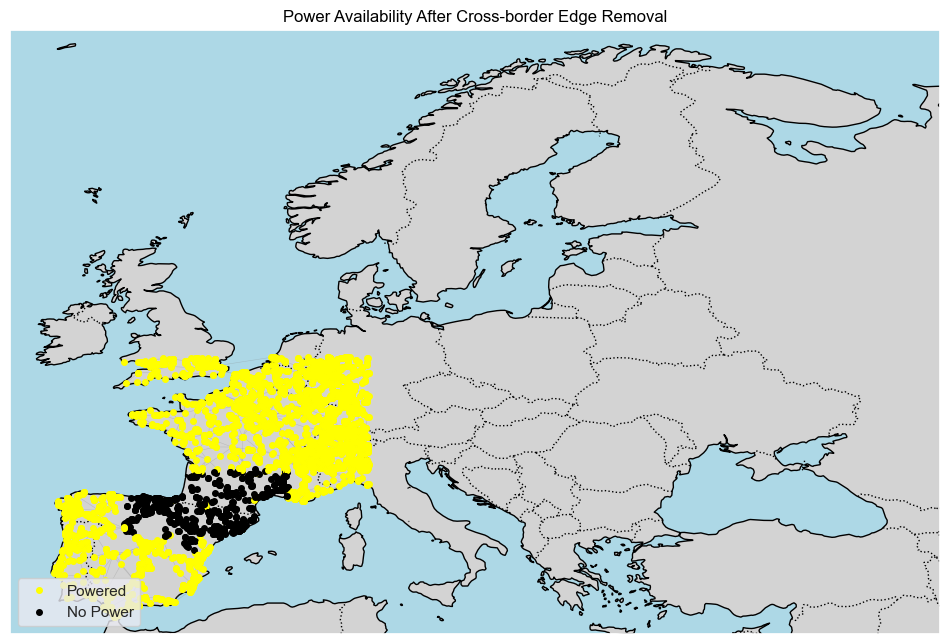

In [ ]:
plot_power_availability(G_cut, powered_after_cut, title="Power Availability After Cross-border Edge Removal")

In [ ]:
def plot_power_availability1(G, generators, removal_percents, iberia_nodes_set, role=None):
    """
    Plot power availability maps after progressive removal of nodes in graph G,
    but only show and count Iberian Peninsula nodes in the visualization and stats.
    """

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    total_iberia_nodes = len(iberia_nodes_set)
    nodes_to_remove = [n for n, d in G.nodes(data=True) if (role is None or d.get('role') == role)]
    nodes_sorted = sorted(nodes_to_remove, key=lambda n: G.degree(n), reverse=True)

    n_plots = len(removal_percents)
    ncols = min(3, n_plots)
    nrows = (n_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten() if n_plots > 1 else [axs]

    for i, perc in enumerate(removal_percents):
        G_copy = G.copy()
        num_to_remove = int(perc * len(nodes_sorted))
        remove_nodes = nodes_sorted[:num_to_remove]
        G_copy.remove_nodes_from(remove_nodes)

        # Update generators in current graph copy
        generators_new = {n for n, d in G_copy.nodes(data=True) if d.get('role') == 'generation'}

        powered_nodes = get_powered_nodes(G_copy, generators_new)

        # Only consider Iberian nodes in the counts and plotting
        powered_iberia = [n for n in powered_nodes if n in iberia_nodes_set]

        ax = axs[i]
        ax.set_title(f"{int(perc*100)}% Nodes Removed\nPowered Iberia: {len(powered_iberia)}/{total_iberia_nodes}")

        # Map background and features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())

        # Plot edges inside Iberia only (both endpoints in Iberia)
        for u, v in G_copy.edges():
            if u in iberia_nodes_set and v in iberia_nodes_set:
                x1, y1 = G_copy.nodes[u]['pos']
                x2, y2 = G_copy.nodes[v]['pos']
                ax.plot([x1, x2], [y1, y2], color='gray', linewidth=0.4, alpha=0.3, transform=ccrs.Geodetic())

        # Plot Iberian nodes only, color by powered or not
        for n in iberia_nodes_set:
            if n in G_copy.nodes:
                x, y = G_copy.nodes[n]['pos']
                color = 'yellow' if n in powered_iberia else 'black'
                ax.plot(x, y, 'o', color=color, markersize=4, transform=ccrs.PlateCarree())

    # Hide extra axes if any
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


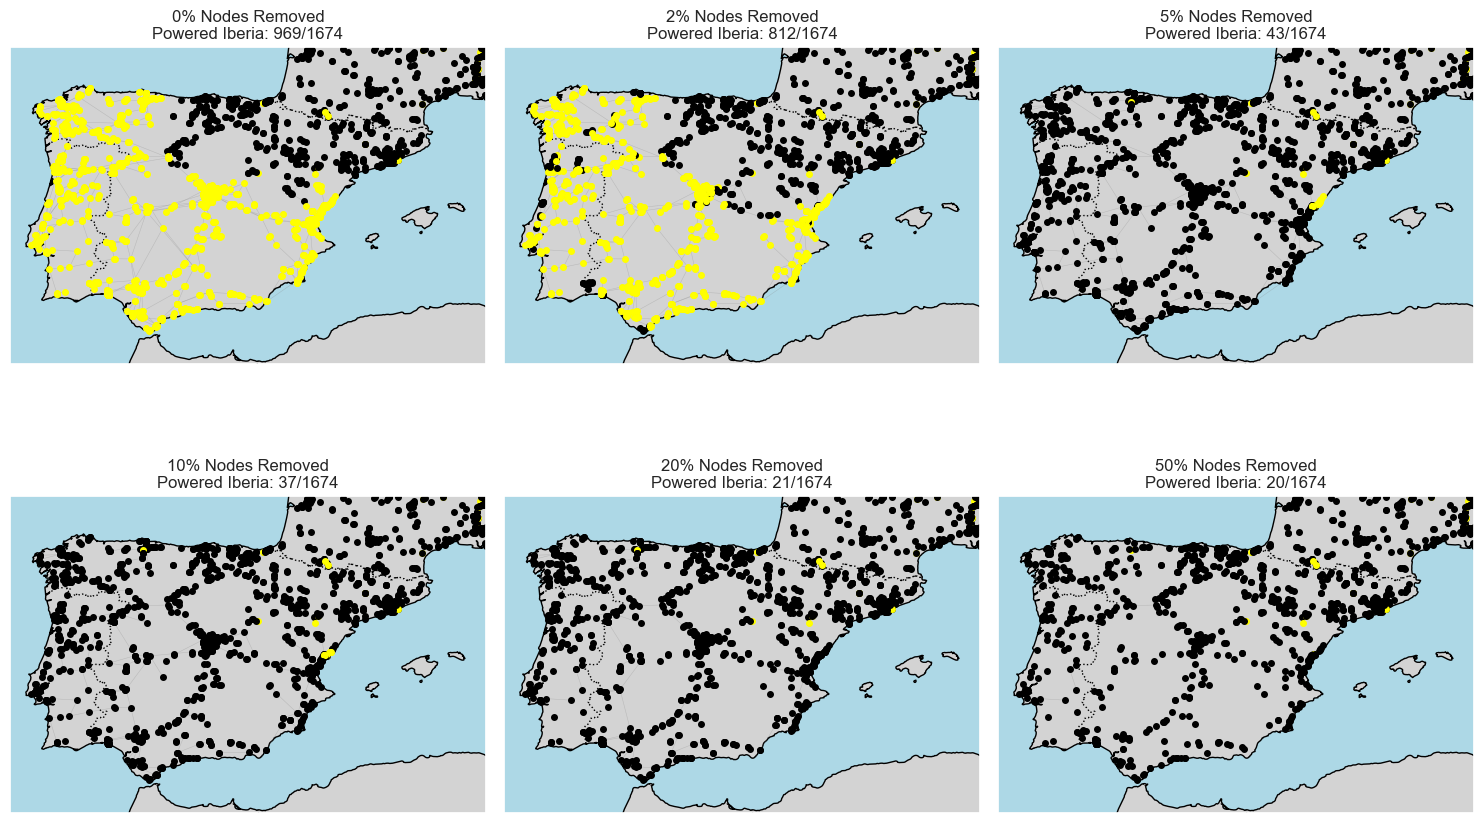

In [ ]:
iberia_nodes_set = set(iberia_nodes) 

generators_iberia_france = {n for n, d in G_cut.nodes(data=True) if d.get('role') == 'generation'}
removal_percents = [0, 0.02, 0.05, 0.10, 0.20, 0.50]
plot_power_availability1(G_cut, generators_iberia_france, removal_percents, iberia_nodes_set)